In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### imports

In [2]:
print(__doc__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

Automatically created module for IPython interactive environment


### utilities

In [3]:
def sigmoid(x):
    return 1 / (1 + (np.e**-x))

def infer_topic(doc_vector, topic_word_distr):
    doc_topic_word_distr = topic_word_distr.copy()
    doc_word_freq_norm = (doc_vector > 0).astype(int)
#     doc_word_freq_norm = doc_vector / doc_vector.sum() if doc_vector.sum() else 0

    for label_class in label_classes:
        doc_topic_word_distr[label_class] *= doc_word_freq_norm
    
    
    doc_topic = np.max(doc_topic_word_distr).idxmax()
    return doc_topic_word_distr, doc_topic

### load dataset

In [4]:
# total number of samples needed
datasize = 1000

# retrieve dataset
docs = fetch_20newsgroups(subset='train', shuffle=False, remove=('headers', 'footers', 'quotes'))
docs, old_labels, classes = docs.data[:datasize], docs.target[:datasize], docs.target_names

In [5]:
# the actual labels as np array
old_labels = np.array(old_labels)
labels = np.zeros(old_labels.shape, dtype=int)

# the new classes
label_classes = list(set([x.split('.')[0] for x in classes]))

# restructuring classes  from 19 to less
for label, cl in enumerate(classes):
    labels[old_labels == label] = label_classes.index(cl.split('.')[0])

In [6]:
print(f"there are {len(docs)} docs and {len(label_classes)} classes: {label_classes}")

there are 1000 docs and 7 classes: ['rec', 'sci', 'misc', 'comp', 'alt', 'talk', 'soc']


### clean dataset

In [7]:
# clean out the new line characters from text in docs
def clean_doc(doc):
    ''' remove unwanter characters line new line '''

    unwanted_chrs = [')', '(', '{', '}', '\t', '\n', '\r', "'", '"', "!"]
    doc = doc.lower()
    for unwanted_chr in unwanted_chrs:
        doc = doc.replace(unwanted_chr, ' ')

    return doc.strip()

clean_docs = [clean_doc(doc) for doc in docs]
clean_docs[0]

'morgan and guzman will have era s 1 run higher than last year, and  the cubs will be idiots and not pitch harkey as much as hibbard.  castillo won t be good  i think he s a stud pitcher'

### count words

In [8]:
# initialize the count vectorizer
count_vectorizer = CountVectorizer()
# count_vectorizer = TfidfVectorizer()

# fit it to dataset
count_vectorizer.fit(clean_docs)

words = count_vectorizer.get_feature_names()

print("word_count is", len(words))

word_count is 19476


### Prepare Datatset

In [9]:
# create doc count vectors
doc_vectors = count_vectorizer.transform(clean_docs).toarray()



train_doc_vectors, test_doc_vectors, train_labels, test_labels = train_test_split(doc_vectors, labels, test_size=.33, random_state=42)
print(f"{len(train_labels)} train_docs, {len(test_labels)} test docs")

670 train_docs, 330 test docs


In [10]:
document_word_frequency = pd.DataFrame(train_doc_vectors, columns=count_vectorizer.get_feature_names())
document_word_binary_frequency = (document_word_frequency > 0).astype('int')

document_word_frequency["__labels__"] = train_labels
document_word_binary_frequency["__labels__"] = train_labels

print("document_word_frequency shape is", document_word_frequency.shape)

document_word_frequency shape is (670, 19477)


In [11]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes")

there are 1000 docs and 7 classes


In [12]:
document_word_frequency.head()

,00,000,0000,00000000,00000000b,00000001,00000001b,00000010,00000010b,00000011,...,zoom,zoomed,zooming,zubov,zum,zupancic,zx,zx900a,zzz,__labels__
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
document_word_binary_frequency.head()

,00,000,0000,00000000,00000000b,00000001,00000001b,00000010,00000010b,00000011,...,zoom,zoomed,zooming,zubov,zum,zupancic,zx,zx900a,zzz,__labels__
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Prepare Binary Dataset

In [83]:
#reduce freq in doc to bin value of 1 or 0
# word_doc_binary_freqency = document_word_binary_frequency.drop(["__labels__"], axis='columns')
word_doc_binary_freqency = document_word_frequency.drop(["__labels__"], axis='columns')

#the sum vertically of bin freq
word_doc_frequency = word_doc_binary_freqency.sum(0) 

### Topic and word corelation

In [84]:
topic_word_distr = pd.DataFrame(data=0.0, columns=label_classes, index=words)

for topic, label in enumerate(label_classes):
    word_topic_frequency = word_doc_binary_freqency[document_word_frequency['__labels__'] == topic].sum(0)
    trust_factor = sigmoid(word_doc_frequency)
    
    topic_word_distr[label] = ((word_topic_frequency * trust_factor) / word_doc_frequency).fillna(0)
    
print(f"topic_word_distr has shape {topic_word_distr.shape}")

topic_word_distr has shape (19476, 7)


In [85]:
topic_word_distr.head()

,rec,sci,misc,comp,alt,talk,soc
00,0.083333,0.083333,0.166666,0.083333,0.0,0.499997,0.083333
000,0.266667,0.133333,0.066667,0.066667,0.0,0.466667,0.000000
0000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
00000000,0.000000,0.880797,0.000000,0.000000,0.0,0.000000,0.000000
00000000b,0.000000,0.880797,0.000000,0.000000,0.0,0.000000,0.000000


In [86]:
label_classes

['rec', 'sci', 'misc', 'comp', 'alt', 'talk', 'soc']

In [87]:
label_class = 'comp'
topic_word_distr[label_class][topic_word_distr[label_class] > 0].sort_values(ascending=False)

3t            1.000000
1d9           1.000000
b8f           1.000000
wm            1.000000
9v            1.000000
                ...   
game          0.014706
him           0.013605
government    0.011494
si            0.010417
db            0.005415
Name: comp, Length: 4148, dtype: float64

In [88]:
topic_word_distr.loc["the"]

rec     0.145125
sci     0.175471
misc    0.016297
comp    0.131498
alt     0.025709
talk    0.431582
soc     0.074319
Name: the, dtype: float64

### Word word corelation

In [138]:
word_word_distr = pd.DataFrame(data=0.0, columns=words, index=words)

for word in tqdm(words):
    word_word_frequency = word_doc_binary_freqency[word_doc_binary_freqency[word] > 0].sum(0)
    trust_factor = sigmoid(word_doc_frequency)

    word_word_co = ((word_word_frequency * trust_factor) / word_doc_frequency).fillna(0)
    word_word_distr[word][word_word_co > word_word_distr[word]] = word_word_co[word_word_co > word_word_distr[word]]

word_word_distr = word_word_distr.T
print("word_word_distr has shape", word_word_distr.shape)


word_word_distr has shape (5550, 5550)


In [139]:
word_word_distr.head()

,00,000,0188,02026,04110,0837,0988,0q,0qax,0qq,...,z5,z6e1,z6e1t,z6ei,zealand,zeh,zip,zirconium,zone,zoomed
00,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
000,0.0,0.880797,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
0188,0.0,0.000000,0.731059,0.731059,0.0,0.731059,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.440399,0.0,0.0,0.0
02026,0.0,0.000000,0.731059,0.731059,0.0,0.731059,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.440399,0.0,0.0,0.0
04110,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [140]:
word = "computer"
word_word_distr[word][word_word_distr[word] > .5].sort_values(ascending=False)

of              0.952574
computer        0.952574
machine         0.952574
for             0.952574
am              0.952574
an              0.952574
and             0.952574
to              0.952574
one             0.952574
be              0.952574
in              0.952574
the             0.952574
out             0.952574
have            0.635049
if              0.635049
is              0.635049
functions       0.635049
it              0.635049
just            0.635049
has             0.635049
fast            0.635049
from            0.635049
first           0.635049
much            0.635049
by              0.635049
but             0.635049
at              0.635049
as              0.635049
any             0.635049
also            0.635049
all             0.635049
might           0.635049
you             0.635049
not             0.635049
substitution    0.635049
with            0.635049
which           0.635049
well            0.635049
was             0.635049
up              0.635049


### Building topic model

In [173]:
re_topic_word_distr = pd.DataFrame(data=0.0, columns=label_classes, index=words)

for word in tqdm(words):
    word_word_co = word_word_distr[word]
    
    for label_class in label_classes:
        infered_ratio = (word_word_co * topic_word_distr[label_class]).max()
        
        if infered_ratio > re_topic_word_distr[label_class][word]:
            re_topic_word_distr[label_class][word] = infered_ratio
            
print("re_topic_word_distr has shape", re_topic_word_distr.shape)


re_topic_word_distr has shape (5550, 7)


In [174]:
re_topic_word_distr.head()

,talk,sci,alt,rec,soc,misc,comp
00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
000,0.432477,0.559350,0.279675,0.279675,0.279675,0.193951,0.524941
0188,0.464258,0.696387,0.321957,0.464258,0.321957,0.321957,0.538432
02026,0.464258,0.696387,0.321957,0.464258,0.321957,0.321957,0.538432
04110,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [175]:
word = "companies"
re_topic_word_distr.loc[word].sort_values(ascending=False)

sci     0.696387
comp    0.487369
talk    0.364625
misc    0.358955
rec     0.321957
alt     0.321957
soc     0.232129
Name: companies, dtype: float64

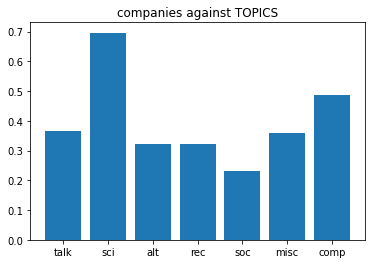

In [176]:
plt.title(f"{word} against TOPICS")
plt.bar(re_topic_word_distr.loc[word].index, re_topic_word_distr.loc[word])
plt.show()

### Evaluating Topic Model

In [89]:
score1 = score2 = 0
print("Evaluating Topic Model...")
for doc_index in tqdm(range(len(train_labels))):
    doc_vector = train_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(doc_vector, topic_word_distr)
    score1 += int(doc_topic == label_classes[train_labels[doc_index]])
    
#     doc_topic_word_distr, doc_topic = infer_topic(doc_vector, re_topic_word_distr)
    score2 += int(doc_topic == label_classes[train_labels[doc_index]])
    
    if score1:
        continue
    
#     print(clean_docs[len(train_labels)+doc_index])
#     print("{:8s} {:16s} {:6s}".format("topic", "word", "relation"))
#     print("="*40)
#     for label, word in doc_topic_word_distr.idxmax().items():
#         print("{:8s} {:16s} {:.4f}".format(label, word, doc_topic_word_distr[label][word]))

#     print(f"\nthe topic predicted is ==> '{np.max(doc_topic_word_distr).idxmax()}'")
#     print(f"the actual topic is ==> '{label_classes[labels[doc_index]]}'")

accuracy1 = score1 / (doc_index + 1)
accuracy2 = score2 / (doc_index + 1)
print(f"==> train-accuracy is {accuracy1*100:.2f}% and re is {accuracy2*100:.2f}%\n")

Evaluating Topic Model...



==> train-accuracy is 91.19% and re is 91.19%



### Testing Topic Model

In [90]:
score1 = score2 = 0
print("Evaluating Topic Model...")
for doc_index in tqdm(range(len(test_labels))):
    doc_vector = test_doc_vectors[doc_index]
    
    doc_topic_word_distr, doc_topic = infer_topic(doc_vector, topic_word_distr)
    score1 += int(doc_topic == label_classes[test_labels[doc_index]])
    
#     doc_topic_word_distr, doc_topic = infer_topic(doc_vector, re_topic_word_distr)
    score2 += int(doc_topic == label_classes[test_labels[doc_index]])
    
    if score1:
        continue
    
#     print(clean_docs[len(train_labels)+doc_index])
#     print("{:8s} {:16s} {:6s}".format("topic", "word", "relation"))
#     print("="*40)
#     for label, word in doc_topic_word_distr.idxmax().items():
#         print("{:8s} {:16s} {:.4f}".format(label, word, doc_topic_word_distr[label][word]))

#     print(f"\nthe topic predicted is ==> '{np.max(doc_topic_word_distr).idxmax()}'")
#     print(f"the actual topic is ==> '{label_classes[labels[doc_index]]}'")

accuracy1 = score1 / (doc_index + 1)
accuracy2 = score2 / (doc_index + 1)
print(f"==> test-accuracy is {accuracy1*100:.2f}% and re is {accuracy2*100:.2f}%\n")

Evaluating Topic Model...



==> test-accuracy is 60.30% and re is 60.30%



In [193]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [274]:
label_classes

['sci', 'soc', 'misc', 'rec', 'alt', 'comp', 'talk']

In [71]:
from sklearn.linear_model import LogisticRegression

X = np.nan_to_num(train_doc_vectors / train_doc_vectors.sum(0))
y = train_labels

clf = LogisticRegression(random_state=0, fit_intercept=False).fit(X, y)
# clf = LogisticRegression(random_state=0, fit_intercept=False, multi_class="multinomial", solver="lbfgs").fit(X, y)

print(len(X), "training data")

c:\users\christian\documents\christian\work\python\cyberspace\semantic_segmentation\venv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


670 training data


In [72]:
np.array(count_vectorizer.get_feature_names())[clf.coef_[3].argsort()][::-1]

array(['nutek', 'crt', 'soundblaster', ..., 'conservatives',
       'informative', 'canceled'], dtype='<U79')

In [73]:
label_classes

['rec', 'sci', 'misc', 'comp', 'alt', 'talk', 'soc']

In [74]:
clf.score(X, y)

0.9776119402985075

In [75]:
XX = np.nan_to_num(test_doc_vectors / test_doc_vectors.sum(0))#[test_labels == 2]
yy = test_labels#[test_labels == 2]

clf.score(XX, yy)

c:\users\christian\documents\christian\work\python\cyberspace\semantic_segmentation\venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


0.6818181818181818

In [67]:
len(test_labels), len(yy)

(330, 330)

In [68]:
from sklearn.linear_model import LogisticRegression

X = np.nan_to_num(train_doc_vectors / train_doc_vectors.sum(0))
y = train_labels

models = []
for index in tqdm(range(len(count_vectorizer.get_feature_names()))):
    clf = LogisticRegression(random_state=0).fit(X[:, index:index+1], y)
    models.append(clf)
    
#     print("training score", clf.score(X[:, index:index+1], y))

c:\users\christian\documents\christian\work\python\cyberspace\semantic_segmentation\venv\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [69]:
XX = np.nan_to_num(test_doc_vectors / test_doc_vectors.sum(0))
yy = test_labels

p = np.zeros((len(XX[:, 0]), 7))

for index in tqdm(range(len(count_vectorizer.get_feature_names()))):
    clf = models[index]
    prob = clf.predict_proba(XX[:, index:index+1])
    p[prob > p] = prob[prob > p]

(p.argmax(1) == yy).mean()

c:\users\christian\documents\christian\work\python\cyberspace\semantic_segmentation\venv\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


0.5151515151515151

0.24242424242424243